Notebook to accompany article by Arseniev-Koehler and Foster, "Teaching an algorithm what it means to be fat: machine-learning as a model for cultural learning." All code last checked on Python 3 in Windows 1/2/2019. Please cite our paper or [GitHub repo](https://github.com/arsena-k/Word2Vec-bias-extraction) if reused. 

# More Manly or Womanly? Measuring Cultural Dimensions in Word2Vec with Support Vector Machines

This research explores how language around body weight in the news is loaded with meanings of gender, morality, healthiness, and socio-economic status (SES). For example, is "obese" more masculine or feminine? What about "slender"? 

In this notebook, we develop and then train a model to classify words with respect to each of these four dimensions (gender, morality, healthiness, and SES) on a set of training words. Then, we test model performance on a fresh set of testing words. 

Finally, we look at how language about body weight, such as "obese" and "slender,"  to see how these words are connoted with gender, morality, health, and social class. 

This notebook, Part D of our project, uses a classical machine-learning method, a Support Vector Machine (SVM), to classify words. For two alternate methods to check the robustness of how we classify words according to these four dimensions, see code for [Part B](https://github.com/arsena-k/Word2Vec-bias-extraction). 

We start by loading up a trained Word2Vec model on news. We include two possible pre-trained models from our paper. See [Part A](https://github.com/arsena-k/Word2Vec-bias-extraction) of this project for a tutorial on training and understanding a Word2Vec model. Or, for a review of Word2Vec see this [blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). 

**Table of Contents**

* Part 1. [Load up libraries and a Word2Vec Model](#Starting)
* Part 2: [Explanation of Classification Method](#Motivation)
* Part 3: [Load up Training/Testing Words](#LoadUp)
* Part 4: [Robustness Checks](#Robustness)
* Part 5: [Visualize how this Dimension Classifies words according to Gender, Morality, Health, and SES](#Results)


*This is a long notebook. You can skip Part 4 (robustness checks) if you want to get right to the results.*

<a id='Staring'></a> 
# Part 1. Load up libraries and a Word2Vec Model

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import KFold 
from statistics import mean, stdev
from sklearn import datasets, decomposition, preprocessing, svm
from os import getcwd
from random import seed
from seaborn import stripplot
from pylab import rcParams
from pylab import xlim
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline
cwd= getcwd()
seed(2018)

**Load up a pretrained Word2Vec Model**

*Option 1:* Use the Word2Vec model that we used in our paper, and trained on obesity and health related New York Times articles. Please see our paper for training details. 
* Download our model, called 'modelA_ALLYEARS_300dim_10CW' from our [OSF](https://osf.io/jvarx/files/), and put it in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory. 

In [10]:
#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_300dim_10CW" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA_ALLYEARS_300dim_10CW")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_300dim_10CW" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA_ALLYEARS_300dim_10CW")

#   Example based on my set-up of folders:
currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Dropbox/GSRM/LexisNexis Data/Word2VecModels/modelA_ALLYEARS_300dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer

*Option 2:* Use a pretrained Word2Vec Model from Google, trained on Google News
* Download a pre-trained model on GoogleNews, described on this [site](https://code.google.com/archive/p/word2vec/) and [download the model here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).
* Extract the downloaded files, and make sure you have the file called "GoogleNews-vectors-negative300.bin.gz" in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. As written, the code assumes that your downloads folder is your working directory. 
* Some of the vocabulary words used in this notebook may not exist in the Google News model, since the vocabulary words used in this paper were selected based on a Word2Vec model trained on the New York Times. 

In [ ]:
#   An example for a PC computer if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format('C:/Users/Alina Arseniev/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)

#   An example for a Mac if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format("~/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)

#   Example based on my set-up of folders:
currentmodel=  KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


<a id='Motivation'></a> 
# Part 2. Explanation of The Classification Method

This method trains four machine-learning classifiers (specifically,  **Support Vector Machines**, or SVM) to classify words according to four dimensions: as feminine/masculine, moral/immoral, healthy/unhealthy, and high/low socio-econonic status (SES). We feed in a training set of word-vectors we strongly expect to lie at one end of the dimensions or the other. For each of the four dimensions, an SVM model *learns* a hyperplane that separates the two classes. 

A limitation of this machine-learning method, in contrast with the geometric classification methods in part B, is that SVM models **risk being overparametertrized and overfitted.** This is because word-vectors tend to be a few hundred-dimensions and we have usually only have around 100 training words to learn a dimensions, so we often have more "features" than "training examples." Cross-validation and the use of a fresh set of testing words helps us understand how much our model may be overfitted. Using cross-validation, we found that using PCA to reduce the dimensionality of word-vectors further did *not* improve results. We also only use a linear SVM model, and try out other possible machine-learning models (like a random forest) as comparison machine-learned models. 

* In our experiments, initially we found that results from our SVM model to classify obesity words by gender did not corroborate our results using classification methods in Part B. In fact, these words were seemingly classified without pattern. This was also surprising to us given the large body of qualitaitve literature suggesting how our concepts of body weight is gendered. We hypothesized that this mismatch in empirical results may be because gender training words are the most "sharply" or "widely" separated - **our training words were too easy**. Indeed, many of our training words for gender are explicilty and largely defined by their gendered meanings, such as "he", "him", and "man", "man" and "machismo."  In contrast, training words for other dimensions, like "yuppie" for classifying SES, carry more layers of meaning than just social class. "Yuppie," for example, also carries meaning about age and urbanization. 
* Thus, the gendered differences in our training set may be *too easy* to classify, leading the model to overfit to these training cases. To test this, we added some noisy words into our training words for gender, using words we thought were more implicitly gendered (e.g., “independent” as masculine, and “dependent” as feminine). We used two versions of updated training words, to vary the number of noisy word-vectors added. In both cases, words about body weight were now classified in ways that corroborated findings from our other two methods. Testing accuracy also increased using the more noisy training words for gender. In this notebook, we use thhe revised gender training set is to get results. When we used these revised training sets for the other two classification methods, there were no changes in initial empirical findings, suggesting that our other two methods are more robust to overfitting. 

<a id='LoadUp'></a> 
# Part 3. Create a Dataset of Training and Testing Word-Vectors

In [18]:
%run helpers_partC.py #helpers_partD.py has a lot of longer functions that we'll use, in a separate file so that this notebook is more visually appealing
# %load helpers_partC.py #uncomment and run this to directly see ALL contents of helpers_partC.py that we'll use, but the most important ones are explained below

**select_training_set()** is a function to select correponding training words to represent the two ends of the dimension:

* Under the hood, this function includes sets of words that represent extremes of the dimension we want to capture. 
* To look at the final list of words, check out "train_word_list_checked" or refer to the code in helpers_partD.py
* Our methods were developed using a Word2Vec model trained on the New York Times, so the vocabulary used in training and testing may not exactly match the vocabulary of your model. If a word is not in the vocabulary of your model, this function by default lets you know and then replaces the word with a generic word. For example, if "teenage_girl", or "twin_sister" is not in the vocabulary they will be replaced with the generic feminine word for the gender dimension, "woman." 

It is *fed*:
* the dimension we're interested in ('gender', 'moral', 'health', or 'ses')
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel

It *returns*:
* train_word_list_checked= list of the words used for training the classifier for the dimension selected
* train_words= word-vectors corresponding to words used for training the classifier for the dimension selected
* train_classes= expected classes of words used for training the classifier for the dimension selected

It also *prints* the number of positive and negative words used in training.

In [19]:
#example of how to use
train_word_list_checked, train_words, train_classes = select_training_set('gender', currentmodel)

Number of pos train words: 85 Number of neg train words: 85


<a id='Robustness'></a> 
# Part 4. Robustness Checks

**FIRST, Let's see how robust our methods are to the specific training words we use. We'll do cross validation on training words:**

Cross validation, with **do_kfold()** lets us see how well our dimension classifies our training words. More specifically, we use a subset of training words to extract the dimension and and look at how the dimension classifies 1) this subset of words and 2) the held-out words. We can do this for various subsets and look the range of accuracies. As coded, each training subset includes all but one training word ("leave one out" cross validation). This process tells us, for example, how robust our methods are to our word choices, and if there is any overfitting to the training words. 

This function is *fed* a dimenions ('gender', 'moral', 'health', or 'ses') and a trained Word2Vec model. It *returns* the average and standard deviation of accuracies across the multiple training subset and held-out subsets. 

In [13]:
do_kfold('gender' , currentmodel)

Number of pos train words: 85 Number of neg train words: 85
Mean Accuracy across Training Subsets:0.9424643230073094
Standard Deviation of Accuracy across Training Subsets:0.0035841517500854137
Mean Accuracy across Held-Out Subsets: 0.888235294117647
Standard Deviation of Accuracy across Held-Out Subsets: 0.316007551668392


In [14]:
do_kfold('moral' , currentmodel) 

Number of pos train words: 80 Number of neg train words: 80
Mean Accuracy across Training Subsets:0.9846305031446541
Standard Deviation of Accuracy across Training Subsets:0.005675821351093611
Mean Accuracy across Held-Out Subsets: 0.975
Standard Deviation of Accuracy across Held-Out Subsets: 0.15661513939205382


In [15]:
do_kfold('health' , currentmodel)

Number of pos train words: 65 Number of neg train words: 65
Mean Accuracy across Training Subsets:0.9661299940369708
Standard Deviation of Accuracy across Training Subsets:0.004934810083743951
Mean Accuracy across Held-Out Subsets: 0.9230769230769231
Standard Deviation of Accuracy across Held-Out Subsets: 0.26750018808613585


In [16]:
do_kfold('ses' , currentmodel)

Number of pos train words: 50 Number of neg train words: 50
Mean Accuracy across Training Subsets:0.9901010101010101
Standard Deviation of Accuracy across Training Subsets:0.001421265597336253
Mean Accuracy across Held-Out Subsets: 0.91
Standard Deviation of Accuracy across Held-Out Subsets: 0.28762349126466136


**NOW, let's see how well our SVM machine-learning classifers works on all training data:**

In [20]:
#select here what you want to classify: 'gender', 'moral, 'health', or 'ses'
train_word_list_checked, train_words, train_classes= select_training_set('gender', currentmodel) #can change 'gender' to each of the other 3 dimensions of interest

#train the model and do predictions
clf=svm.SVC(kernel='linear', C=1) #set up classifier hyperparameters
clf = clf.fit(train_words, train_classes) #train classifier on all training data
predictions =clf.predict(train_words) #make predictions on training words
print('\033[1m' +'Accuracy on Training Data with SVM Classifier:'  + '\033[0m'+ str(accuracy_score(train_classes, predictions)))

Number of pos train words: 85 Number of neg train words: 85
Accuracy on Training Data with SVM Classifier:0.9411764705882353


<a id='Results'></a> 
# Part 5. Results

Select the dimension you're interested in:

In [27]:
current_subspace = subspaceselector("gender") #choose, gender, moral, health, or ses

Get all the training and testing data:

In [28]:
test_word_list_checked, test_words, test_classes, train_word_list_checked, train_words, train_classes = select_testing_set(current_subspace.subspaceselection, currentmodel)

Number of pos train words: 81 Number of neg train words: 81
Number of test words in model vocabulary, out of 60: 60


Get Results using an SVM Model:

In [29]:
seed(20)
clf=svm.SVC(kernel='linear', C=1) 
clf = clf.fit(train_words, train_classes)
train_predictions =clf.predict(train_words) 
test_predictions =clf.predict(test_words) 

print('\033[1m' +'% Accuracy on Training Data with SVM Classifier:'  + '\033[0m'+ str(accuracy_score(train_classes, train_predictions)) )
print('\033[1m' +'% Accuracy on Testing Data with SVM Classifier:'  + '\033[0m'+ str(accuracy_score(test_classes, test_predictions)) )

print('\033[1m' +'N Accuracy on Training Data with SVM Classifier:'  + '\033[0m'+ str(accuracy_score(train_classes, train_predictions, normalize=False)) )
print('\033[1m' +'N Accuracy on Testing Data with SVM Classifier:'  + '\033[0m'+ str(accuracy_score(test_classes, test_predictions, normalize=False)) )

% Accuracy on Training Data with SVM Classifier:0.9444444444444444
% Accuracy on Testing Data with SVM Classifier:0.9833333333333333
N Accuracy on Training Data with SVM Classifier:153
N Accuracy on Testing Data with SVM Classifier:59


Visualize Testing Results

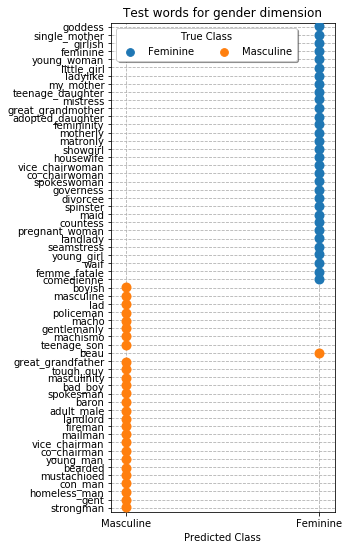

In [30]:
rcParams['figure.figsize'] = 4,9
#xlim([-.03, .03])

test_classes_relabeled=[] #get legend to show name of expected class instead of 0/1
for i in test_classes:
    if i==1:
        test_classes_relabeled.append(current_subspace.pos_coded)
    else:
        test_classes_relabeled.append(current_subspace.neg_coded)

test_predictions_unipolar=[]
for i in test_predictions:
    test_predictions_unipolar.append(i)


myplot= stripplot(test_predictions_unipolar, test_word_list_checked, test_classes_relabeled, jitter=True, size=10)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title="True Class", fancybox=True)

plt.title('Test words for '+ current_subspace.subspaceselection + ' dimension')
plt.xlabel('Predicted Class')
myplot.grid(b=True, linestyle='dashed')
locs, labels = plt.xticks((0,1), ( current_subspace.neg_coded,  current_subspace.pos_coded)) 
plt.show()

Visualize Results about Obesity Lexicon

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


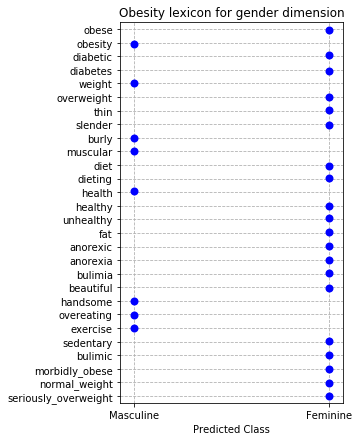

In [31]:
#get predicted results for obesity lexicon
obese_words_seeifinmodel=['obese', 'obesity', 'diabetic', 'diabetes', 'weight', 'overweight', 'thin', 'slender', 'burly',
                'muscular', 'diet', 'dieting', 'health', 'healthy', 'unhealthy', 'fat', 'anorexic', 'anorexia', 'bulimia', 
                'beautiful', 'handsome', 'overeating', 'exercise', 'sedentary', 'bulimic', 'morbidly_obese', 'normal_weight',
                'seriously_overweight']
obese_word_list= []
obese_words=[]

#check if these words are in your model
for i in range(0, len(obese_words_seeifinmodel)):
    try:
        currentmodel[obese_words_seeifinmodel[i]]
        obese_words.append(currentmodel[obese_words_seeifinmodel[i]])
        obese_word_list.append(obese_words_seeifinmodel[i])
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue
obese_words=np.asarray(obese_words)
obese_words = preprocessing.normalize(obese_words, norm='l2')
obese_predictions =clf.predict(obese_words) 

#make visual
rcParams['figure.figsize'] = 4,7
#xlim([-.03, .03])

obese_predictions_unipolar=[]
for i in obese_predictions:
    obese_predictions_unipolar.append(i)
        
myplot= stripplot(obese_predictions_unipolar, obese_word_list, color= 'blue', jitter=True, size=8)
#myplot.xticks(np.arange(0,1))
plt.title('Obesity lexicon for '+ current_subspace.subspaceselection + ' dimension')
plt.xlabel('Predicted Class')
locs, labels = plt.xticks((0,1), ( current_subspace.neg_coded,  current_subspace.pos_coded))
myplot.grid(b=True, linestyle='dashed')

plt.show()